In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pydicom
from pathlib import Path

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('/home/paperspace/data/pneumonia/')
list(PATH.iterdir())

[PosixPath('/home/paperspace/data/pneumonia/sub_mean.csv'),
 PosixPath('/home/paperspace/data/pneumonia/image_bbox_full.csv'),
 PosixPath('/home/paperspace/data/pneumonia/test.png'),
 PosixPath('/home/paperspace/data/pneumonia/train_png512'),
 PosixPath('/home/paperspace/data/pneumonia/test'),
 PosixPath('/home/paperspace/data/pneumonia/stage_1_detailed_class_info.csv'),
 PosixPath('/home/paperspace/data/pneumonia/stage_1_detailed_class_info.csv.zip'),
 PosixPath('/home/paperspace/data/pneumonia/stage_1_train_labels.csv.zip'),
 PosixPath('/home/paperspace/data/pneumonia/bbox_mapl.pkl'),
 PosixPath('/home/paperspace/data/pneumonia/stage_1_test_images.zip'),
 PosixPath('/home/paperspace/data/pneumonia/models'),
 PosixPath('/home/paperspace/data/pneumonia/test_png128'),
 PosixPath('/home/paperspace/data/pneumonia/train'),
 PosixPath('/home/paperspace/data/pneumonia/train_png128'),
 PosixPath('/home/paperspace/data/pneumonia/tmp'),
 PosixPath('/home/paperspace/data/pneumonia/stage_1_train_

In [5]:
bbox_path = PATH/'image_bbox_full.csv'
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

28989 boxes loaded
25684 patient cases


,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex
13549,880a1959-2f94-4572-8ed9-041d0d85e2dc,599.0,452.0,214.0,287.0,1,Lung Opacity,1,/home/paperspace/data/pneumonia/train/880a1959...,73,CHEST,AP,F
23432,d2e58976-fb07-41f3-b7c5-bd9418c6e15a,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/d2e58976...,37,CHEST,AP,F
3042,35b7784f-f4e5-453c-9d6b-e6c1eff5c7be,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/35b7784f...,43,CHEST,PA,F


In [6]:
pneu = bbox_df[bbox_df.Target==1]
len(pneu['patientId'].unique())

5659

In [7]:
grouped = bbox_df.groupby('patientId')
target_list=[(patient, group.iloc[0].path, group.iloc[0].Target) for patient, group in grouped]

In [8]:
target_list[:5]

[('0004cfab-14fd-4e49-80ba-63a80b6bddd6',
  '/home/paperspace/data/pneumonia/train/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
  0),
 ('00313ee0-9eaa-42f4-b0ab-c148ed3241cd',
  '/home/paperspace/data/pneumonia/train/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm',
  0),
 ('00322d4d-1c29-4943-afc9-b6754be640eb',
  '/home/paperspace/data/pneumonia/train/00322d4d-1c29-4943-afc9-b6754be640eb.dcm',
  0),
 ('003d8fa0-6bf1-40ed-b54c-ac657f8495c5',
  '/home/paperspace/data/pneumonia/train/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm',
  0),
 ('00436515-870c-4b36-a041-de91049b9ab4',
  '/home/paperspace/data/pneumonia/train/00436515-870c-4b36-a041-de91049b9ab4.dcm',
  1)]

In [18]:
dir = PATH/'train_png512'
for file in dir.iterdir():
    new_name =file.name[len('train_png'):]
    file.rename(dir/new_name)


In [ ]:
def generate_pngs(target_list, size):
    dir = PATH/f'train_png{size}/'
    printed = 0
    for id, path, target in target_list:
        dicom = pydicom.read_file(path)
        data = dicom.pixel_array
        img = Image.fromarray(data)
        img = img.resize((size,size), Image.ANTIALIAS)
        img.save(f'{dir}/{id}.png')
        printed += 1
        if printed % 500 == 0:
            print('Saved ', printed)
generate_pngs(target_list,512)

Saved  500
Saved  1000
Saved  1500
Saved  2000
Saved  2500
Saved  3000
Saved  3500
Saved  4000
Saved  4500
Saved  5000
Saved  5500
Saved  6000
Saved  6500
Saved  7000
Saved  7500
Saved  8000
Saved  8500
Saved  9000
Saved  9500
Saved  10000
Saved  10500
Saved  11000
Saved  11500
Saved  12000
Saved  12500
Saved  13000
Saved  13500
Saved  14000
Saved  14500
Saved  15000
Saved  15500
Saved  16000
Saved  16500
Saved  17000
Saved  17500
Saved  18000
Saved  18500
Saved  19000
Saved  19500
Saved  20000
Saved  20500
Saved  21000
Saved  21500
Saved  22000
Saved  22500
Saved  23000
Saved  23500
Saved  24000


In [ ]:
def generate_test_pngs(file_list, size):
    dir = PATH/f'test_png{size}/'
    printed = 0
    for path,id in file_list:
        dicom = pydicom.read_file(path)
        data = dicom.pixel_array
        img = Image.fromarray(data)
        img = img.resize((size,size), Image.ANTIALIAS)
        img.save(f'{dir}/{id}.png')
        printed += 1
        if printed % 500 == 0:
            print('Saved ', printed)
    

In [ ]:
file_id = [(str(path), path.stem) for path in (PATH/'test').iterdir()]
generate_test_pngs(file_id,512)


Saved  500


In [53]:
file_target = [(id+".png", target)  for (id,_,target) in target_list]
target_df = pd.DataFrame(file_target, columns=['file', 'target'])
target_df.to_csv(f'{PATH}file2target.csv', header=True,index=False)

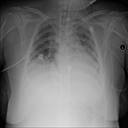

In [26]:
PIL.Image.open('/home/paperspace/data/pneumonia/train_png128/00436515-870c-4b36-a041-de91049b9ab4.png')